In [15]:
%load_ext autoreload
%autoreload 2
from sklearn.utils import shuffle
from utils import *
from topic_modeling import *
from download_edgar: import *
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Get the training documents from 1 year:
docs = query_docs(2018, 2019, 'Trade & Services', 'Business Services', False)[0]

In [19]:
# Covert documents to tokens, bag of word and dictionary format:
texts, bows, dic = tokens_bows_dict(docs, 5, 0.5)

In [21]:
# Get train and test set:
texts_train, texts_test, bows_train, bows_test = train_test_split(texts, bows)

In [22]:
# Build models for comparison:
models, coherences, perplexities = models_codherence_perplexity(\
        texts_train, texts_test, bows_train, bows_test, dic)

Building model of 10 topics
Building model of 20 topics
Building model of 30 topics
Building model of 40 topics
Building model of 50 topics
Building model of 60 topics
Building model of 70 topics
Building model of 80 topics
Building model of 90 topics
Building model of 100 topics
Building model of 110 topics
Building model of 120 topics
Building model of 130 topics
Building model of 140 topics
Building model of 150 topics
Building model of 160 topics
Building model of 170 topics
Building model of 180 topics
Building model of 190 topics
Building model of 200 topics


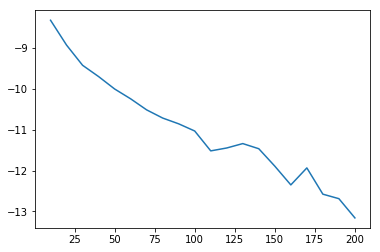

In [25]:
# Plot perplexity vs number of topics:
plt.plot(range(10, 201, 10), perplexities)

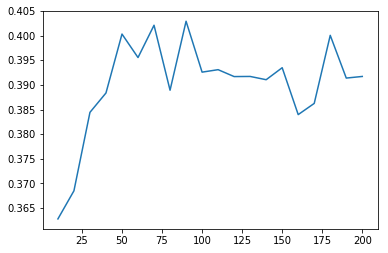

In [26]:
# Plot coherence vs number of topics:
plt.plot(range(10, 201, 10), coherences)

In [29]:
# Sorting topics base on coherence on train data:
models[9].top_topics(texts=texts_train, coherence='c_v', topn=10)

[([(0.18105568, 'diagnost'),
   (0.067412145, 'laboratori'),
   (0.060713857, 'medicar'),
   (0.051036876, 'payer'),
   (0.05090804, 'patient'),
   (0.044987593, 'clinic'),
   (0.044944003, 'cancer'),
   (0.033756107, 'healthcar'),
   (0.03330332, 'physician'),
   (0.015578756, 'hospit')],
  0.9454044477169674),
 ([(0.10074232, 'healthcar'),
   (0.089958526, 'patient'),
   (0.05134485, 'clinic'),
   (0.04909606, 'medic'),
   (0.041102566, 'payer'),
   (0.033436578, 'physician'),
   (0.022064716, 'pharmaceut'),
   (0.016938541, 'drug'),
   (0.01666925, 'hipaa'),
   (0.015668811, 'popul')],
  0.8390460616506962),
 ([(0.25264874, 'cannabi'),
   (0.076840766, 'marijuana'),
   (0.07016945, 'colorado'),
   (0.030532124, 'home'),
   (0.028817464, 'cultiv'),
   (0.02797557, 'medic'),
   (0.027885256, 'denver'),
   (0.024909947, 'warehous'),
   (0.024544436, 'buyer'),
   (0.024299173, 'tenant')],
  0.8362370916304777),
 ([(0.16108264, 'energi'),
   (0.07306961, 'wast'),
   (0.06426929, 'china')